### Exploratory Notebook Trying to Get MHD Orzang Tang looking nice... 


In [1]:

import os

#using GPU, comment out if on CPU?
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
import jax
jax.config.update("jax_disable_jit", False)

jax.config.update("jax_debug_nans", True)
print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


/tmp/ipykernel_105492/1101825997.py:12: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(jax.lib.xla_bridge.get_backend().platform_version)  # sanity: shows CUDA/cuDNN


PJRT C API
cuda 12030


In [3]:
#load athena ICs (not used in this version)
import h5py
import jax.numpy as jnp


In [4]:
import diffhydro as dh


eq = dh.equationmanager_mhd.EquationManagerMHD()
eq.mesh_shape=[256,256,1]

In [5]:
def orszag_tang_2d(eq, embed_in_3d: bool = True):
    # use eq.mesh_shape and optional eq.box_size
    import jax.numpy as jnp

    nx, ny = eq.mesh_shape[0], eq.mesh_shape[1]
    nz = eq.mesh_shape[2] if (len(eq.mesh_shape) > 2) else 1
    box_size = getattr(eq, "box_size", (2.0 * jnp.pi, 2.0 * jnp.pi, 1.0))
    Lx, Ly = float(box_size[0]), float(box_size[1])

    x = (jnp.arange(nx) + 0.5) * (Lx / nx)
    y = (jnp.arange(ny) + 0.5) * (Ly / ny)
    X, Y = jnp.meshgrid(x, y, indexing="ij")

    rho0 = 25.0 / (36.0 * jnp.pi)
    p0   =  5.0 / (12.0 * jnp.pi)

    rho = jnp.ones((nx, ny)) * rho0
    u   = -jnp.sin(Y); v = jnp.sin(X); w = jnp.zeros_like(u)
    Bx  = -jnp.sin(1.0*Y); By = 0.5 * jnp.sin(2.0 * X); Bz = jnp.zeros_like(u)
    p   = jnp.ones_like(u) * p0

    W2 = jnp.stack([rho, u, v, w, Bx, By, Bz, p], axis=0)  # (8, nx, ny)

    W = jnp.repeat(W2[..., jnp.newaxis], nz, axis=-1) if embed_in_3d else W2
    U = eq.get_conservatives_from_primitives(W)

    #GLM, not tried
    if getattr(eq, "n_cons", U.shape[0]) == 9 and U.shape[0] == 8:
        psi = jnp.zeros_like(U[0])
        U = jnp.vstack([U, psi[jnp.newaxis, ...]])

    t_final = 0.5
    return U, t_final

In [6]:
IC,_ = orszag_tang_2d(eq)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


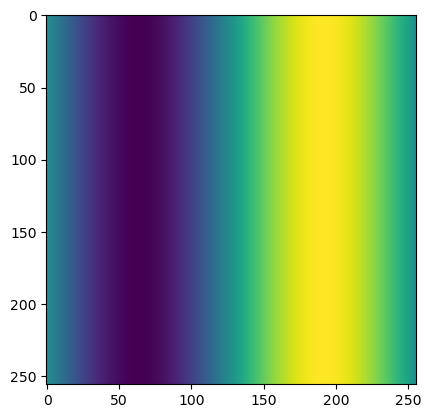

In [7]:
%pylab inline
imshow(IC[-4])

In [8]:
from diffhydro.solver.riemann_solver import RiemannSolver

In [9]:
eq.cfl= 0.2
solver = dh.HLLD_MHD(equation_manager=eq,signal_speed=None)
cf = dh.ConvectiveFlux(eq,solver,dh.MUSCL3(limiter="VANLEER"),positivity=False)
hydro = dh.hydro_ct(n_super_step=1500, fluxes=[cf],forces=[],use_mol=True,use_ct=True, integrator="RK2") 



using CTU? True


In [10]:
params = {}
output = hydro.evolve(IC,params)

using CTU? True
using CTU? True


In [11]:
def divB(U):
    Bx, By, Bz = U[4], U[5], U[6]
    dx = hydro.dx_o
    return ((Bx - jnp.roll(Bx, 1, axis=0)) +
            (By - jnp.roll(By, 1, axis=1)) +
            (Bz - jnp.roll(Bz, 1, axis=2))) / dx


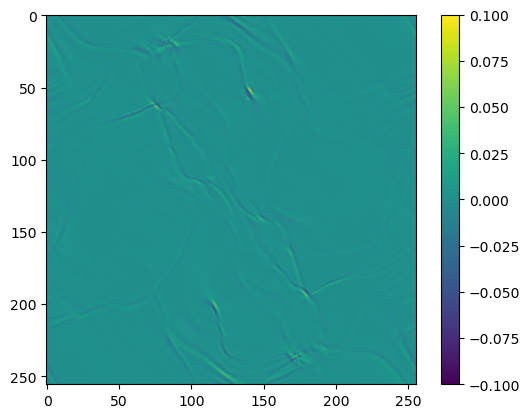

In [17]:
#still some divergence ripples...
imshow(divB(output[0]),vmin=-0.1,vmax=0.1)
colorbar()

In [19]:
field_out = output[0]
field_out_prim = eq.get_primitives_from_conservatives(field_out)

cf.timestep(output[0])

Array(0.04052302, dtype=float32)

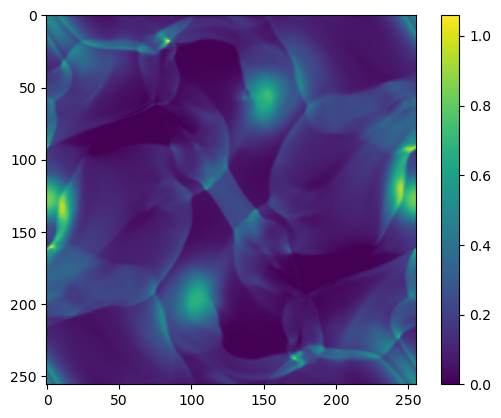

In [20]:
imshow(field_out_prim[-1][:,:,0])
plt.colorbar()

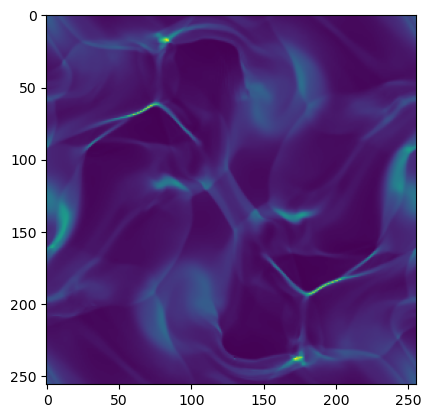

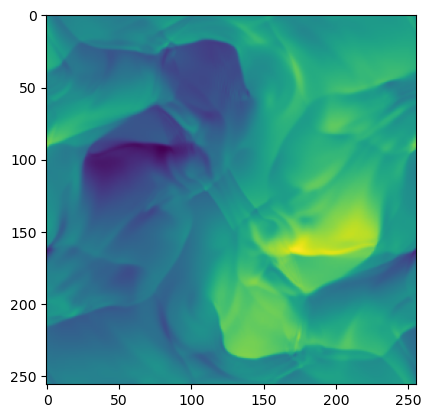

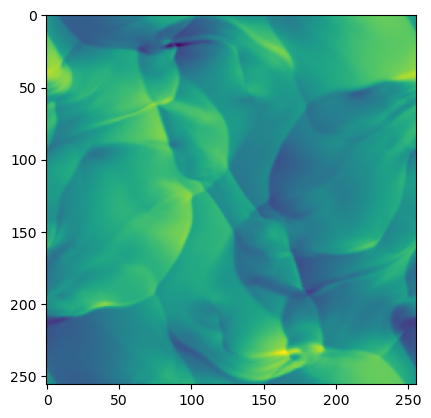

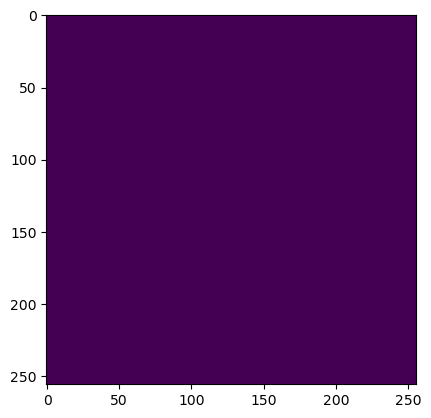

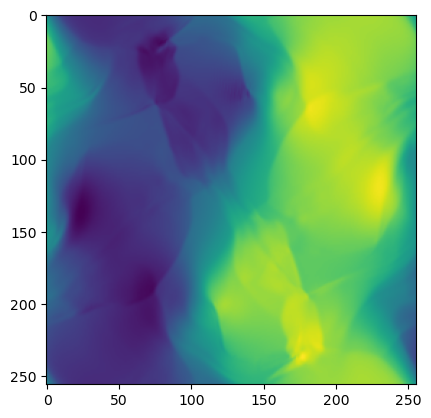

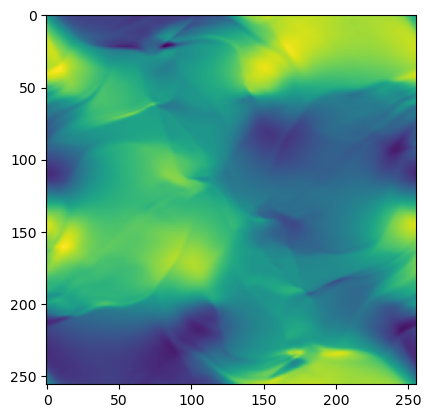

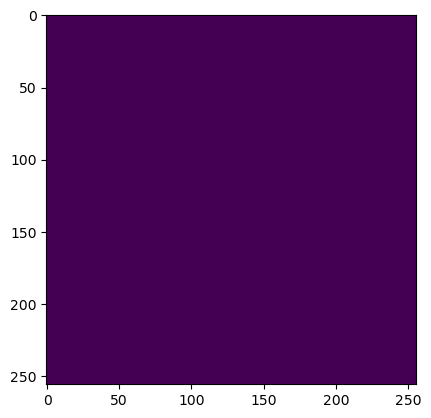

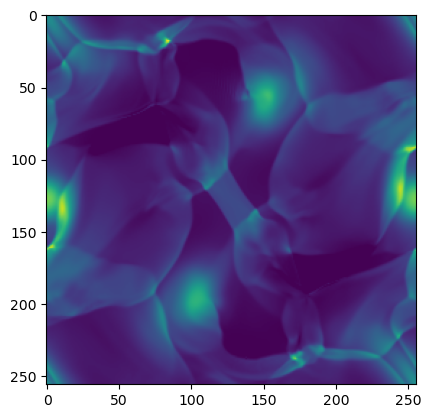

In [21]:

for i in range(0,8):
    imshow(field_out_prim[i][:,:,0])
    show()
    